# Types of Inference Models
*Version 1.0*

To navigate up and down, you can use the up and down arrow keys on your keyboard<br />
To execute code in this workbook, select the code block and press **Shift+Enter** <br />
To edit the code block, press enter. 

The codes in this workbook are cumulative. (Variables defined continue to be available until the notebook is closed) <br />
So do start from the top and work your way down to avoid unexpected results!


For more help on using Jupyter Notebook, you can click on Help > User Interface Tour in the menu above, <br />
or visit https://jupyter-notebook.readthedocs.io/en/stable/ui_components.html

Experiment and test out your ideas, for that is one of the fastest ways to learn!

## 1. What can machine learning models predict?

In the last workshop, you trained a model that took in an image (as input), and returned a prediction of which class it belonged to (as output). That was a form of **classification**. Some of you went further to determine where the cards were within the image. That was a form of **localization**. And some of you went on to classify which class each individual pixel in the image belonged to. That was a form of **image segmentation**.

In general, machine learning models take feature vectors as inputs. For computer vision, these feature vectors are calculated from the images. They are then fed into the model which consequently predicts a set of output. These outputs may include:

- For **image classification**, a class label for the image
- For **localization**, a class label for the image, and coordinates for the bounding box.
- For **object detection**, a list of bounding boxes (and class labels for object recognition) for objects detected.
- For **image segmentation**, a class label for each pixel in the image
- The output may also include the probability scores for the different class labels.

Today's workshop will introduce Convolutional Neural Networks (CNN), and then go on to explore how to make use of pre-trained models for classification and object detection in the real world.
1. What are Convolutional Neural Networks
1. How to use the Intel® OpenVINO™ Inference Engine with OpenCV
1. How to make inferences on the Intel Neural Compute Stick 2

## Convolutional Neural Networks (CNN)

In the last workshop, we made use of basic machine learning algorithms such as kNN and SVM. In recent years, Convolutional Neural Networks (CNN) have gained great popularity due to its effectiveness. CNNs are a form of Neural Networks that are made up of a series of convolution filters. And the network learns the optimal filters (also known as weights) through the process of training. 

**What are convolutions?**

In simple terms, convolutions are a mathematical operations performed on the input to produce an output. It can also be used as a form of feature extraction. 

Convolutions can also be used for basic image processing. For example, blurring, sharpening, averaging, and bilateral filtering.

For CNNs, the model learns the optimal weights each of the convolution operations during training (instead of having them manually defined). Optimization techniques such as gradient descent are used (together with back propagation of errors) in order to calculate the optimal "weights" for each of the convolutions. We will not be going into the detailed implementation or math in this workshop, but you are always encouraged to [learn more](http://deeplearning.stanford.edu/tutorial/supervised/ConvolutionalNeuralNetwork/). 

### 1.1 Convolutions

Let us just apply a few convolution filters on a photograph of a printed circuit board (PCB) to somewhat visualize the concept of convolutions. **cv2.filter2D** is an image processing function in OpenCV that can be used to perform convolutions https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/filter_2d/filter_2d.html

<img src="images/convolutions.png" />

Notice how the words and circuit board patterns are clearer and sharper after some convolution filters are applied, compared to others. Does it remind you of thresholding in the earlier workshop? Convolutions can be used to extract meaningful features from input images. And in the context of CNNs, a series of convolutions are typically used (and not just 1).

Let us work through some code.

In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image

# Let's quickly recap the code to read in an image
image = cv2.imread("images/pcb.png")

# We convert it to greyscale to illustrate 2D convolutions.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cv2_imshow(gray)

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


Let's try to blur this image using a convolution filter as follows. How does the result compare to the original?

In [4]:
kernel1 = np.ones((19,19),np.float32)/361      # a 19x19 convolution filter
filter1 = cv2.filter2D(gray,-1,kernel1)

cv2_imshow(filter1)

Let's try another filter

In [6]:
kernel2 = np.array((                        # a 3x3 convolution filter
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]), np.float32)*2
filter2 = cv2.filter2D(gray,-1,kernel2)

cv2_imshow(filter2)

Did you notice the 3x3 array of numbers in the code above? That is the convolution filter that is used to perform the mathematical operations on the input image. [Read more](http://ufldl.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/#convolutions) to see how the image can be transformed to a convolved feature using a filter like this. The example in the link illustrates the resulting feature vector output as smaller than the input. However, in our examples, the output maintains the same size as the input because cv2.filter2D adds a padding automatically.

Let's try 1 more filter

In [8]:
kernel3 = np.array((
    [-2, -2, 0],
    [-2, 1, 2],
    [0, 2, 2]), dtype="int")           
filter3 = cv2.filter2D(gray,-1,kernel3)  

cv2_imshow(filter3)

Did you notice the 3x3 array of numbers again? In the context of CNNs, those numbers are known as weights of the respective convolutional (CONV) layers which the CNN will learn as part of the model training process.

Convolutional Neural Networks typically contain a series of convolutional layers (CONV), and are used together with Activation and Pooling Layers. Activation layers are usually applied after every CONV layer and Pooling layers are used to reduce the spatial dimensions. Dropout layers may also be added to prevent overfitting. The detailed implementation is outside the scope of this workshop, but you are encouraged to [read more](http://cs231n.github.io/convolutional-networks/#layers)

When training is complete, the CNN can be used to make predictions just like other machine learning models.

## 2. The Intel&reg; OpenVINO&trade; Inference Engine

Let us now switch gears to use some pre-trained CNNs. We heard about CNNs, let us now see them in action. the Intel&reg; OpenVINO&trade; Toolkit ships together with some pre-trained models that you can use. You can also use the Model Optimizer to convert models trained on other frameworks such as Caffe, MxNet, and Tensorflow. The toolkit currently supports running the optimized models on either CPU, GPU, FPGA or MYRIAD (the NCS2).

### The Model Optimizer is available at:
%OPENVINO_INSTALL_DIR%/Intel/computer_vision_sdk/deployment_tools/model_optimizer 

You can run the model optimizer by activating the cv environment (where you installed Python 3.6) <br />
and run **python mo.py** with the required arguments.


### For the FP32 data type, more commonly used for CPUs:
(replace %PATH_TO_MODEL% and %PATH_TO_OUTPUT% accordingly)

python mo.py --input_model "%PATH_TO_MODEL%\squeezenet1.1.caffemodel" --output_dir "%PATH_TO_OUTPUT%/FP32" --data_type FP32

### For the FP16 data type, more commonly used for NCS2:

(replace %PATH_TO_MODEL% and %PATH_TO_OUTPUT% accordingly)

python mo.py --input_model "%PATH_TO_MODEL%\squeezenet1.1.caffemodel" --output_dir "%PATH_TO_OUTPUT%/FP16" --data_type FP16


To give you a smoother start, some models have already been converted for you in the "models" subdirectory

Bonus: You can learn more about FP16 and FP32 [here](https://www.quora.com/What-is-the-difference-between-FP16-and-FP32-when-doing-deep-learning)


### 2.1 Sample Model for Classification (running on CPU)

Documentation for the Intel® OpenVINO™ Python API is available [online](https://software.intel.com/en-us/articles/OpenVINO-InferEngine#overview-of-inference-engine-python-api)

As of 18 January 2019, the documentation says "**NOTE: This is a preview version of the Inference Engine Python* API for evaluation purpose only. Module structure and API itself will be changed in future releases.**"

Hence, it is likely that the API will be updated eventually. For now, let us explore how to use it.

The Intel® OpenVINO™ installation also comes with a sample python file that performs classification. You can find the file at %OPENVINO_INSTALL_DIR%/Intel/computer_vision_sdk/inference_engine/python_samples/classification_sample.py 

Alternatively, you can execute the code below, and the results will be displayed. It will first show the neural network being loaded, and then the classification results (beginning with the class labels that have the highest probability).

### Classifying between 1000 different image classes with SqueezeNet

This model has been trained to recognize images from 1000 classes. You can read more about the project  [here](https://arxiv.org/abs/1602.07360).

Next, let us try to make use of this model to make some classifications.

Apart from the example below, you can also try a few other images such as images/dog.jpeg, images/hamster.jpeg and images/bluecar.jpeg

In [10]:
!python classification_sample.py -i images/cat.jpeg -m models/squeezenet1.1/FP32/squeezenet1.1.xml --labels models/squeezenet1.1/FP32/squeezenet1.1.labels

[ INFO ] Creating Inference Engine
[ INFO ] Loading network:
	models/squeezenet1.1/FP32/squeezenet1.1.xml
[ INFO ] Preparing input blobs
[ WARNING ] Image images/cat.jpeg is resized from (1500, 2034) to (227, 227)
[ INFO ] Batch size is 1
[ INFO ] Loading model to the plugin
[ INFO ] Start inference (10 Asynchronous executions)
[ INFO ] Completed 1 Async request execution
[ INFO ] Completed 2 Async request execution
[ INFO ] Completed 3 Async request execution
[ INFO ] Completed 4 Async request execution
[ INFO ] Completed 5 Async request execution
[ INFO ] Completed 6 Async request execution
[ INFO ] Completed 7 Async request execution
[ INFO ] Completed 8 Async request execution
[ INFO ] Completed 9 Async request execution
[ INFO ] Completed 10 Async request execution
[ INFO ] Processing output blob
[ INFO ] Top 10 results: 
Image images/cat.jpeg

classid probability
------- -----------
  cat      0.7695200
tabby cat 0.1498853
  cat    0.0361377
catamount 0.0187889
  cat    0.0087181

### Task: Classify at least 1 more photo from the folder ./images!

In [11]:
!python classification_sample.py -i images/bluecar.jpeg -m models/squeezenet1.1/FP32/squeezenet1.1.xml --labels models/squeezenet1.1/FP32/squeezenet1.1.labels

[ INFO ] Creating Inference Engine
[ INFO ] Loading network:
	models/squeezenet1.1/FP32/squeezenet1.1.xml
[ INFO ] Preparing input blobs
[ WARNING ] Image images/bluecar.jpeg is resized from (1416, 2520) to (227, 227)
[ INFO ] Batch size is 1
[ INFO ] Loading model to the plugin
[ INFO ] Start inference (10 Asynchronous executions)
[ INFO ] Completed 1 Async request execution
[ INFO ] Completed 2 Async request execution
[ INFO ] Completed 3 Async request execution
[ INFO ] Completed 4 Async request execution
[ INFO ] Completed 5 Async request execution
[ INFO ] Completed 6 Async request execution
[ INFO ] Completed 7 Async request execution
[ INFO ] Completed 8 Async request execution
[ INFO ] Completed 9 Async request execution
[ INFO ] Completed 10 Async request execution
[ INFO ] Processing output blob
[ INFO ] Top 10 results: 
Image images/bluecar.jpeg

classid probability
------- -----------
wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon0.2936821
rad

Do try out more images and explore why some images might be misclassified, especially those with more objects in the background. 

Next, we will be exploring how to run the same model on the NCS2, a portable USB device that is designed to speed up inference tasks on edge devices. It can also be used on your laptop.


### 2.2 Sample model for Classification (running on NCS2)

The Neural Compute Stick is intended to make inferences a breeze, especially for larger networks. Let us see how we can run our inference on the NCS2 instead of on our CPU.

First, you need to plugin in the NCS2 into a USB port on your computer. If you have a USB3.0 port, use it for faster data transfer speeds. Then you just need to execute the code below.

How different is it from the code above?

We have added **-d MYRIAD** to specify to use the NCS2 instead of the CPU. (Myriad is actually the name of the powerful chip that is inside the NCS2) And we have also updated the model path to the FP16 directory instead of the FP32 directory. This is because the NCS2 only supports **FP16**, while CPUs tend to use FP32.

In [12]:
!python classification_sample.py -d MYRIAD -i images/cat.jpeg -m models/squeezenet1.1/FP16/squeezenet1.1.xml --labels models/squeezenet1.1/FP16/squeezenet1.1.labels

[ INFO ] Creating Inference Engine
[ INFO ] Loading network:
	models/squeezenet1.1/FP16/squeezenet1.1.xml
[ INFO ] Preparing input blobs
[ WARNING ] Image images/cat.jpeg is resized from (1500, 2034) to (227, 227)
[ INFO ] Batch size is 1
[ INFO ] Loading model to the plugin
Traceback (most recent call last):
  File "classification_sample.py", line 175, in <module>
    sys.exit(main() or 0)
  File "classification_sample.py", line 133, in main
    exec_net = ie.load_network(network=net, device_name=args.device)
  File "ie_api.pyx", line 413, in openvino.inference_engine.ie_api.IECore.load_network
  File "ie_api.pyx", line 457, in openvino.inference_engine.ie_api.IECore.load_network
RuntimeError: Cannot load library 'libopenvino_intel_myriad_plugin.so: libopenvino_intel_myriad_plugin.so: cannot open shared object file: No such file or directory


### Task: Classify at least 1 more photo from the folder ./images!

In [13]:
!python classification_sample.py -d MYRIAD -i images/cat.jpeg -m models/squeezenet1.1/FP16/squeezenet1.1.xml --labels models/squeezenet1.1/FP16/squeezenet1.1.labels

[ INFO ] Creating Inference Engine
[ INFO ] Loading network:
	models/squeezenet1.1/FP16/squeezenet1.1.xml
[ INFO ] Preparing input blobs
[ WARNING ] Image images/cat.jpeg is resized from (1500, 2034) to (227, 227)
[ INFO ] Batch size is 1
[ INFO ] Loading model to the plugin
Traceback (most recent call last):
  File "classification_sample.py", line 175, in <module>
    sys.exit(main() or 0)
  File "classification_sample.py", line 133, in main
    exec_net = ie.load_network(network=net, device_name=args.device)
  File "ie_api.pyx", line 413, in openvino.inference_engine.ie_api.IECore.load_network
  File "ie_api.pyx", line 457, in openvino.inference_engine.ie_api.IECore.load_network
RuntimeError: Cannot load library 'libopenvino_intel_myriad_plugin.so: libopenvino_intel_myriad_plugin.so: cannot open shared object file: No such file or directory


The probabilities generated on the CPU vs. NCS2 might have some differences due to the way that floating points are supported/calculated. Remeber that we used the FP16 model for the NCS2 and the FP32 model for the CPU. These 2 models are not exactly the same. If you look at the model file sizes in the models subdirectory, you would notice that the .bin file for the FP16 model tends to be much smaller than the .bin file for the FP32 model.

Comparing the results on your CPU and on the NCS2, you might only find minor improvements in running time for this Network as it is a small network that runs quickly within 10-20ms. However, as we will see later on, there are some of the Intel Pre-Trained models that can run on the NCS2 that are currently not supported via CPU. But before we go down the rabbit hole, let us pause here and take a look at the code inside classification_sample.py to understand the logic.


**After using the model, let us dig deeper into the code**

As the code was originally written in C++ for greater efficiency, python wrappers have been created and these are the IEPlugin and IENetwork modules from the openvino.inference_engine package

As a start, you might want to open up classification_sample.py to understand the code. The general idea is to:
1. Initialize the hardware via IEPlugin (CPU / Myriad / GPU / FPGA)
2. Load the network via IENetwork
3. Preprocess the input image into the required format
4. Make the prediction via exec_net.infer
5. Processes/Display the output
6. Release Memory. i.e. del plugin, del net and del exec_net. While the del keyword is less commonly seen in python applications, it seems to be required in order to release the load on the NCS2 (when run from the Jupyter Notebook). When it is run directly via command line, there might be automatic release once the script finishes execution.   

Before proceeding, do open "classification_sample.py" to briefly read through the code.

### 2.3 Using a Python Class to make things easier

Often, we do not really want to implement the lower level codes over and over again. If you recall the previous workshop, once the model was loaded from the sklearn package, there was an awesome method called **model.predict()**. 

Similarly, can we can just load the CNN model, and then use something similar to model.predict to generate the predictions?

Yes, we can.

Let us use a helper class from https://github.com/simpledevelopments/OpenVINO-Python-Utils 
The package has been tested to work on the 2018R5 release of the Intel&reg; OpenVINO&trade; Toolkit. As the Inference Engine Python API is subject to change, our code might need to be updated eventually when the time comes. 

In [14]:
import cv2
import numpy as np
from utils.opv import OpvModel      # Helper class for OpenVINO 2018R5

In [15]:
# If you encounter the error "Can not init USB device: NC_DEVICE_NOT_FOUND", 
#   check that the NCS2 is plugged into your USB port. 
#
# After you no longer need mymodel to make any more inferences, 
#   run mymodel.ClearMachine() to release the application from the device.

mymodel = OpvModel("squeezenet1.1", device="CPU", fp="FP16", ncs=1, debug=True)

[INFO] Model squeezenet1.1 Loaded and Ready on NCS device 1


In [16]:
predictions = mymodel.Predict(cv2.imread("images/cat.jpeg"))

	[INFO] Image resized from (1500, 2034) to (227, 227)


In [17]:
def displayresults(predictions, labels=None):
    if (labels is None):                         # If no labels provided, use numerical labels
        labels = np.arange(0,1000).astype("str")
    predictions = predictions.reshape(1000)
    top5 = predictions.argsort()[-5:][::-1]
    top5results = np.column_stack([predictions[top5], labels[top5]])
    for (conf, label) in top5results:
        print(str(round(float(conf)*100,1))+"% chance: "+label)

displayresults(predictions,mymodel.labels)

77.0% chance: Persian cat
15.0% chance: tabby, tabby cat
3.6% chance: tiger cat
1.9% chance: lynx, catamount
0.9% chance: Egyptian cat


Compare the results with section 2.2 that was also run on the NCS2. The results should match.

### Side note: Revision on NumPy array.
See below to find out how to sort and subset NumPy arrays!

In [18]:
import numpy as np

a = np.array([1, 2, 3, 4, 5, 2, 1])
print(a)

[1 2 3 4 5 2 1]


In [19]:
np.sort(a)
print (np.sort(a))

[1 1 2 2 3 4 5]


In [20]:
np.flip(np.sort(a))
print (np.flip(np.sort(a)))

[5 4 3 2 2 1 1]


In [21]:
np.flip(np.sort(a))[:2]
print (np.flip(np.sort(a))[:2])

[5 4]


In [22]:
print(a.argsort()[-2:][: :-1]) #getting indices of the value 5 and 4

[4 3]


In [23]:
a[a.argsort()[-2:][: :-1]]
print(a[a.argsort()[-2:][: :-1]])

[5 4]


**2.3.1 How were those results neatly formatted?**

Are you wondering what that code did? Let us go step by step,starting from the predictions

We are expecting 1000 records, each displaying the probability of the image belonging to that particular class. But predictions.shape shows our array in the form (1,1000,1,1). Hence the first step to reshape it to a 1D array 

In [24]:
print(predictions.shape)

(1, 1000, 1, 1)


In [25]:
predictions = predictions.reshape(1000)

In [26]:
print(predictions.shape)

(1000,)


**2.3.2 How do we get the array indices for the top 5 results?**

To learn more about numpy, visit https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.argsort.html

In [27]:
predictions.argsort()[-5:][::-1]

array([283, 281, 282, 287, 285])

**2.3.3 What are the probabilities for each of these "top" predictions?**

They are represented in decimal format (1 means 100% confidence. 0.1 means 10% confidence)

In [28]:
predictions[predictions.argsort()[-5:][::-1]]

array([0.76952   , 0.14988528, 0.03613765, 0.01878892, 0.0087181 ],
      dtype=float32)

**2.3.4 And what are the class labels for these predictions?**

For this particular example, when we loaded the model, the labels for the different classes were also loaded from the squeezenet1.1.labels (inside the models/squeezenet1.1/FP16 subdirectory) Hence, we can access it using mymodel.labels. Let's just print the first 5 records. You can cross check against the squeezenet1.1.labels file.

In [16]:
print(mymodel.labels[:5])

['tench, Tinca tinca' 'goldfish, Carassius auratus'
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'
 'tiger shark, Galeocerdo cuvieri' 'hammerhead, hammerhead shark']


**2.3.5 Great, but how do we apply the labels to the predictions?**

Here are the top 5 results!

In [17]:
mymodel.labels[predictions.argsort()[-5:][::-1]]

array(['Persian cat', 'tabby, tabby cat', 'tiger cat', 'lynx, catamount',
       'Egyptian cat'], dtype='<U121')

**2.3.6 Now how might we combine both the probabilities and the results into an array?**

In [18]:
top5 = predictions.argsort()[-5:][::-1]
np.column_stack([    predictions[top5],    mymodel.labels[top5]     ])

array([['0.76951975', 'Persian cat'],
       ['0.14988552', 'tabby, tabby cat'],
       ['0.036137916', 'tiger cat'],
       ['0.018788986', 'lynx, catamount'],
       ['0.00871813', 'Egyptian cat']], dtype='<U121')


**2.3.7 Here's everything put together again**

In [19]:
def displayresults(predictions, labels=None):
    if (labels is None):                         # If no labels provided, use numerical labels
        labels = np.arange(0,1000).astype("str")
    predictions = predictions.reshape(1000)
    top5 = predictions.argsort()[-5:][::-1]
    top5results = np.column_stack([predictions[top5], labels[top5]])
    for (conf, label) in top5results:
        print(str(round(float(conf)*100,1))+"% chance: "+label)
displayresults(predictions,mymodel.labels)

77.0% chance: Persian cat
15.0% chance: tabby, tabby cat
3.6% chance: tiger cat
1.9% chance: lynx, catamount
0.9% chance: Egyptian cat


### Task: Putting it all together, make predictions about another image

In [20]:
predictions = mymodel.Predict(cv2.imread("images/bluecar.jpeg"))
displayresults(predictions, mymodel.labels)

	[INFO] Image resized from (1416, 2520) to (227, 227)
29.4% chance: beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
21.2% chance: grille, radiator grille
20.3% chance: minivan
13.0% chance: racer, race car, racing car
10.4% chance: sports car, sport car


Well done! You have successfully performed classification, making use of the pre-trained SqueezeNet1.1 and OpenVINO. Take some time to think about the process of loading the models, performing the classification and displaying the results. You can write your notes in your student activity guide.

## 3. Library of Inference Models

Remember that there are different types of inference models. Some do image classification, some do object detection or even image segmentation. Intel also provides a set of pre-trained inference models together with the Intel® OpenVINO™ installation. You can find out more about the pre-trained models at
https://software.intel.com/en-us/openvino-toolkit/documentation/pretrained-models

**Optimizing models into the IR format**<br />
At the beginning of section 2, we briefly talked about the Model Optimizer. Before Trained Models are run on the Intel® OpenVINO™ Inference Engine, they need to be optimized into an Intermediate Representation (IR) format. In this way, models trained on frameworks such as Caffe, MxNet, and Tensorflow can be converted into the IR format that can be efficiently run using the toolkit. For more details, refer to https://software.intel.com/en-us/articles/OpenVINO-ModelOptimizer

**Pre-Trained models in IR format**<br />
The good news is, for the pre-trained Intel models, they have already been converted into the IR format which means they are ready to be used straight out of the box. These can be found at %OPENVINO_INSTALL_DIR%/Intel/computer_vision_sdk/deployment_tools/intel_models


To use any of those models, you can just copy the respective subfolders into the models subdirectory where this notebook is located.

## 4. Face Detection using a model from the Intel Models "Library"



How do digital cameras detect peoples' faces? Can we also do something like that?

<img src="images/friendsfaces.png" style="width:400px; float:left;" />
<div style="clear:both;"></div>

Let us make use of the **face-detection-adas-0001** model to help us do just that!

### Task: Refer to the model documentation, note down the input and output of the model. 

You can refer to the documentation for this model at %OPENVINO_INSTALL_DIR%/Intel/computer_vision_sdk/deployment_tools/intel_models/face-detection-adas-0001/description/face-detection-adas-0001.html

The network (model) outputs a blob with the shape: [1, 1, N, 7], where N is the number of detected bounding boxes. For each detection, the description has the format: [image_id, label, conf, x_min, y_min, x_max, y_max] (See the 7 variables? That accounts for the 7 in [1,1,N,7])

**Copy the folder "face-detection-adas-0001" from intel_models into your models folder, then let's get started!**

In [30]:
import cv2
import numpy as np
from utils.opv import OpvModel

mymodel2 = OpvModel("face-detection-adas-0001", device="CPU", fp="FP16", ncs=1)

In [31]:
friends = cv2.imread("images/friends.jpeg")
friends = cv2.resize(friends,(1200,710))     #Downsize the image since the original is quite large
predictions = mymodel2.Predict(friends)

In [32]:
predictions.shape

(1, 1, 200, 7)

Compare the shape you've obtained with the output shape presented in the documentation document. You should get the same shape!

How many predictions are there, can you see?

In [ ]:
#there are 200 entries

Now, do you wonder what is included in the predictions variable? 

### Task: List down at least 3 result of the prediction. Notice how they are labelled [image_id, label, conf, x_min, y_min, x_max, y_max]

In [33]:
print(predictions[:,:,0:3,:])

[[[[0.         1.         1.         0.7941595  0.39807254 0.84158474
    0.5066318 ]
   [0.         1.         0.99999964 0.35023394 0.4601197  0.39078203
    0.5425858 ]
   [0.         1.         0.995613   0.5246759  0.4436372  0.5696493
    0.5426169 ]]]]


Alright, it is now time to draw our bounding box! Try the code below!

In [35]:
def DrawBoundingBoxes(predictions, image, conf=0):
    canvas = image.copy()                             # copy instead of modifying the original image
    predictions_1 = predictions[0][0]                 # subset dataframe
    confidence = predictions_1[:,2]                   # getting conf value [image_id, label, conf, x_min, y_min, x_max, y_max]
    topresults = predictions_1[(confidence>conf)]     # choosing only predictions with conf value bigger than treshold
    (h,w) = canvas.shape[:2]                        # 
    for detection in topresults:
        box = detection[3:7] * np.array([w, h, w, h]) # determine box location
        (xmin, ymin, xmax, ymax) = box.astype("int") # assign box location value to xmin, ymin, xmax, ymax

        cv2.rectangle(canvas, (xmin, ymin), (xmax, ymax), (0, 0, 255), 4)  # make a rectangle
        cv2.putText(canvas, str(round(detection[2]*100,1))+"%", (xmin, ymin), # include text
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0,0), 2)
    cv2.putText(canvas, str(len(topresults))+" face(s) detected", (50,50), # include text
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0,0), 2)
    return canvas

cv2_imshow(DrawBoundingBoxes(predictions,friends))

Uh oh, seems that we are drawing far too many boxes. It appears that we have detected 200 bounding boxes. However, not every bounding box may be a face. To see which are valid predictions, we will need to compare the probability scores against a threshold that we set. 

### Task: Use 50% confidence as our threshold. 

Recall how we displayed the results for the classification example, and compare how the code below works.

In [38]:
def DrawBoundingBoxes(predictions, image, conf=0.5):
    canvas = image.copy()                             # copy instead of modifying the original image
    predictions_1 = predictions[0][0]                 # subset dataframe
    confidence = predictions_1[:,2]                   # getting conf value [image_id, label, conf, x_min, y_min, x_max, y_max]
    topresults = predictions_1[(confidence>conf)]     # choosing only predictions with conf value bigger than treshold
    (h,w) = canvas.shape[:2]                        # setting the variable h and w according to image height
    
    #
    for detection in topresults:
        box = detection[3:7] * np.array([w, h, w, h]) # determine box location
        (xmin, ymin, xmax, ymax) = box.astype("int") # assign box location value to xmin, ymin, xmax, ymax

        cv2.rectangle(canvas, (xmin, ymin), (xmax, ymax), (0, 0, 255), 4)  # make a rectangle
        cv2.putText(canvas, str(round(detection[2]*100,1))+"%", (xmin, ymin), # include text
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0,0), 2)
    cv2.putText(canvas, str(len(topresults))+" face(s) detected", (50,50), # include text
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0,0), 2)
    return predictions_1, canvas

predictions_1,x = DrawBoundingBoxes(predictions,friends)

cv2_imshow(x)

Now, what do you see? You see that only our friends' faces are put in the box!

Now, time to test your understanding of the code. 

### Task: Print our confidence variable. What does this variable contain? Can you notice the confidence level referring to the four friends on the image?

In [40]:
confidence = predictions_1[:,2]
print(confidence)

[1.         0.99999964 0.995613   0.9652485  0.01954743 0.01897003
 0.01794285 0.01770019 0.01764669 0.01762705 0.01760949 0.01733035
 0.01699279 0.0169312  0.01667533 0.01658138 0.01621212 0.01598535
 0.01597153 0.01589354 0.01587603 0.01585956 0.01573427 0.01567847
 0.01560695 0.01541475 0.01540965 0.01534923 0.01514685 0.01509106
 0.01504167 0.0150052  0.01474105 0.01465907 0.01453097 0.01449704
 0.01445425 0.01443859 0.0142894  0.01418993 0.01384503 0.0138289
 0.01380085 0.01380065 0.01364382 0.01363705 0.01353545 0.01353053
 0.01335033 0.01334385 0.01331454 0.01328489 0.01327501 0.01315908
 0.01310864 0.01310847 0.01307228 0.01304319 0.013037   0.01303309
 0.01297615 0.01292787 0.01288899 0.01287341 0.01286598 0.0128212
 0.01280035 0.01278295 0.01277385 0.01276266 0.01272041 0.01269994
 0.01265149 0.01264624 0.01263556 0.01261099 0.01256745 0.01253749
 0.01253317 0.01247997 0.01228532 0.0122328  0.01223095 0.01219888
 0.01218047 0.01211947 0.01201286 0.01199868 0.01191019 0.011898

### Task: Print topresults variable. What does it contain? 
Identify again [image_id, label, conf, x_min, y_min, x_max, y_max]

In [41]:
topresults = predictions_1[(confidence>0.5)]
print(topresults)

[[0.         1.         1.         0.7941595  0.39807254 0.84158474
  0.5066318 ]
 [0.         1.         0.99999964 0.35023394 0.4601197  0.39078203
  0.5425858 ]
 [0.         1.         0.995613   0.5246759  0.4436372  0.5696493
  0.5426169 ]
 [0.         1.         0.9652485  0.14379884 0.3284528  0.18969731
  0.41683373]]


### Task: Print out detection [3:7]
What does it refer to?

In [42]:
detection = topresults[0]
detection [3:7]
# answer: it refers to x_min, y_min, x_max, y_max value from the model

array([0.7941595 , 0.39807254, 0.84158474, 0.5066318 ], dtype=float32)

### Task: print the variable box. 
What does it refer to?

In [43]:
(h,w) = x.shape[:2] 
box = detection[3:7] * np.array([w, h, w, h])
print (box)
# answer: it refers to the x_min, y_min, x_max, y_max position on the image

[ 952.99136639  282.63150394 1009.90169048  359.70857203]


Afterwards, you will proceed with drawing the bounding box and the text label. 

### Task: Draw the bounding box again with your own settings. 
This time, change the color and thickness of the box, and the size and type of the font

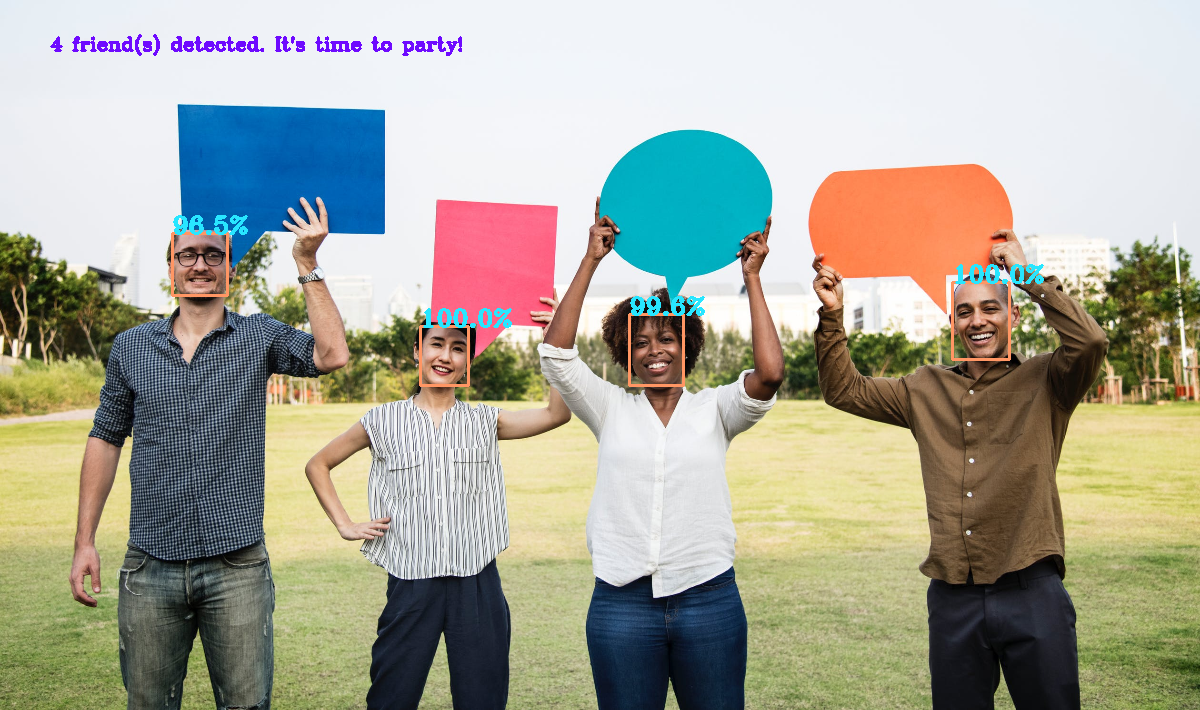

In [44]:
def DrawBoundingBoxes(predictions, image, conf=0.5):
    canvas = image.copy()                             # copy instead of modifying the original image
    predictions_1 = predictions[0][0]                 # subset dataframe
    confidence = predictions_1[:,2]                   # getting conf value [image_id, label, conf, x_min, y_min, x_max, y_max]
    topresults = predictions_1[(confidence>conf)]     # choosing only predictions with conf value bigger than treshold
    (h,w) = canvas.shape[:2]                        # setting the variable h and w according to image height
    
    #
    for detection in topresults:
        box = detection[3:7] * np.array([w, h, w, h]) # determine box location
        (xmin, ymin, xmax, ymax) = box.astype("int") # assign box location value to xmin, ymin, xmax, ymax

        cv2.rectangle(canvas, (xmin, ymin), (xmax, ymax), (100, 150, 255), 2)  # make a rectangle
        cv2.putText(canvas, str(round(detection[2]*100,1))+"%", (xmin, ymin), # include text
            cv2.FONT_HERSHEY_TRIPLEX, 0.8, (255, 230,40), 2)
    cv2.putText(canvas, str(len(topresults))+" friend(s) detected. It's time to party!", (50,50), # include text
            cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 10,110), 2)
    return canvas


cv2_imshow(DrawBoundingBoxes(predictions,friends))

### Task: Use the model to classify and draw a bounding box on another image!
Try images with people facing sideways, making funny faces, etc. What do you notice about the ability of the pre-trained model to look for faces?

In [45]:
friends = cv2.imread("images/friendsinsuit.jpg") #Use another image!
friends = cv2.resize(friends,(1200,710))     #Downsize the image since the original is quite large
predictions = mymodel2.Predict(friends)

In [42]:
def DrawBoundingBoxes(predictions, image, conf=0.5):
    canvas = image.copy()                             # copy instead of modifying the original image
    predictions_1 = predictions[0][0]                 # subset dataframe
    confidence = predictions_1[:,2]                   # getting conf value [image_id, label, conf, x_min, y_min, x_max, y_max]
    topresults = predictions_1[(confidence>conf)]     # choosing only predictions with conf value bigger than treshold
    (h,w) = canvas.shape[:2]                        # setting the variable h and w according to image height
    
    #
    for detection in topresults:
        box = detection[3:7] * np.array([w, h, w, h]) # determine box location
        (xmin, ymin, xmax, ymax) = box.astype("int") # assign box location value to xmin, ymin, xmax, ymax

        cv2.rectangle(canvas, (xmin, ymin), (xmax, ymax), (0, 0, 255), 4)  # make a rectangle
        cv2.putText(canvas, str(round(detection[2]*100,1))+"%", (xmin, ymin), # include text
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0,0), 2)
    cv2.putText(canvas, str(len(topresults))+" face(s) detected", (50,50), # include text
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0,0), 2)
    return canvas

cv2_imshow(DrawBoundingBoxes(predictions,friends))

## Congratulations! You have just built your first face detector!

## It's now time for you to do some hands on! 

You have just used 2 very powerful pre-trained models. One does image classification between 1000 classes of objects, and one does face detection.

As you explore different pre-trained models provided in the Intel® Distribution of OpenVINO™ Toolkit, look into the intel_models subdirectory and into the description subfolder of the respective models. The documentation there will give you a better idea of what the respective models are capable of predicting. Once you have done the predictions, it is back to making use of your basic image processing skills to display the results.

Whatever you build, keep in mind your purpose and objective and think of different possible approaches. As always, also keep in mind the possible impacts when a machine learning algorithm makes a misclassification and plan for ways to mitigate the risks. For example, what is the worst possible consequence of detecting a face when there is actually no face? Or not detecting a face when it is actually there? As with other scenarios where there may be a probability of error, explore complementing the design of your real-world solutions with other techniques or perhaps even hardware sensors.

### Challenge 1: Blur images/dog.jpeg using what you learnt in section 1
Do you also know how to make the blur effect more or less blur?

In [43]:
import cv2
import numpy as np

# Let's quickly recap the code to read in an image
image = cv2.imread("images/dog.jpeg")

# We convert it to greyscale to illustrate 2D convolutions.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

kernel1 = np.ones((19,19),np.float32)/361      # a 19x19 convolution filter
filter1 = cv2.filter2D(gray,-1,kernel1)

kernel2 = np.ones((3,3),np.float32)/9     # a 3x3 convolution filter
filter2 = cv2.filter2D(gray,-1,kernel2)

kernel3 = np.ones((50,50),np.float32)/2500     # a 50x50 convolution filter
filter3 = cv2.filter2D(gray,-1,kernel3)

cv2_imshow(gray)
cv2_imshow(filter1)
cv2_imshow(filter2)
cv2_imshow(filter3)



### Challenge 2: Modify the code in section 2.3 to give the top 3 results instead of top 5

In [44]:
mymodel = OpvModel("squeezenet1.1", device="CPU", fp="FP16", ncs=1, debug=True)
# (self, model_name, device, fp="FP32", debug=False, ncs=1)

Loaded Machine Released
[INFO] Model squeezenet1.1 Loaded and Ready on NCS device 1


In [45]:
predictions.argsort()[-3:][::-1]

array([[[[0, 4, 3, ..., 6, 1, 2],
         [0, 4, 6, ..., 5, 2, 1],
         [0, 4, 6, ..., 5, 2, 1],
         ...,
         [0, 1, 2, ..., 4, 5, 6],
         [0, 1, 2, ..., 4, 5, 6],
         [0, 1, 2, ..., 4, 5, 6]]]], dtype=int64)

### Challenge 3: Load the labels from models/squeezenet1.1/FP16/squeezenet1.1.labels into a numpy array. What is the first label inside the file?

How to you read the labels from file and load it into a numpy array? <br />
Hint: If you get stuck, you might want to check how it is done inside utils/opv.py 

In [46]:
import numpy as np

model_labels = "./models/squeezenet1.1/FP16/squeezenet1.1.labels"
labels = np.loadtxt(model_labels,dtype="str",delimiter="\n")

print (labels)

['tench, Tinca tinca' 'goldfish, Carassius auratus'
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'
 'tiger shark, Galeocerdo cuvieri' 'hammerhead, hammerhead shark'
 'electric ray, crampfish, numbfish, torpedo' 'stingray' 'cock' 'hen'
 'ostrich, Struthio camelus' 'brambling, Fringilla montifringilla'
 'goldfinch, Carduelis carduelis'
 'house finch, linnet, Carpodacus mexicanus' 'junco, snowbird'
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea'
 'robin, American robin, Turdus migratorius' 'bulbul' 'jay' 'magpie'
 'chickadee' 'water ouzel, dipper' 'kite'
 'bald eagle, American eagle, Haliaeetus leucocephalus' 'vulture'
 'great grey owl, great gray owl, Strix nebulosa'
 'European fire salamander, Salamandra salamandra'
 'common newt, Triturus vulgaris' 'eft'
 'spotted salamander, Ambystoma maculatum'
 'axolotl, mud puppy, Ambystoma mexicanum' 'bullfrog, Rana catesbeiana'
 'tree frog, tree-frog'
 'tailed frog, bell toad, ribbed toad, ta

### Challenge 4: Use the classification model to classify images/pcb.png. Does it get classified as a printed circuit board (PCB)? Why do you think so?

In [47]:
!python classification_sample.py -i images/pcb.png -m models/squeezenet1.1/FP32/squeezenet1.1.xml --labels models/squeezenet1.1/FP32/squeezenet1.1.labels


# The model might have not been trained to classify this image

[ INFO ] Loading network files:
	models/squeezenet1.1/FP32/squeezenet1.1.xml
	models/squeezenet1.1/FP32/squeezenet1.1.bin

classification_sample.py:76: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  assert len(net.inputs.keys()) == 1, "Sample supports only single input topologies"



[ INFO ] Preparing input blobs
[ WARNING ] Image images/pcb.png is resized from (480, 640) to (227, 227)
[ INFO ] Batch size is 1
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 3.998279571533203 ms
[ INFO ] Processing output blob
[ INFO ] Top 10 results: 
Image images/pcb.png

0.2059917 label site, website, internet site, site
0.1430571 label sunblock, sun blocker
0.1164520 label lotion
0.0700398 label matchstick
0.0449835 label carton
0.0390331 label Aid
0.0377465 label torch
0.0373017 label packet
0.0287694 label ring-binder
0.0210595 label light, igniter, ignitor




### Challenge 5: Calculate how long it takes to make 1 prediction for the model in section 4.

In [48]:
import time
def wastetime():
    for i in range(0,10000000):
        testing = 1
        
# Sample code for calculating time difference         
a = time.time()
wastetime()
b = time.time()
print(str(b-a) + " seconds")

0.24112176895141602 seconds


In [50]:
import time
import cv2
import numpy as np
from utils.opv import OpvModel

mymodel2 = OpvModel("face-detection-adas-0001", device="CPU", fp="FP16", ncs=1)

friends = cv2.imread("images/friends.jpeg")
friends = cv2.resize(friends,(1200,710))     #Downsize the image since the original is quite large
a = time.time()
predictions = mymodel2.Predict(friends)
b = time.time()
print(str(b-a) + " seconds")

0.024001121520996094 seconds


### Challenge 6: Build an application that does real-time face detection via your webcam.

Hint: Make use of what you learned in section 4, and what you already know about video capture via webcam from the earlier workshop.

In [51]:
camera = cv2.VideoCapture(0) #create a VideoCapture object with the 'first' camera (your webcam)

def DrawBoundingBoxes(predictions, image, conf=0.5):
    canvas = image.copy()                             # copy instead of modifying the original image
    predictions = predictions[0][0]
    confidence = predictions[:,2]
    topresults = predictions[(confidence>conf)]
    (h,w) = canvas.shape[:2]
    for detection in topresults:
        box = detection[3:7] * np.array([w, h, w, h])
        (xmin, ymin, xmax, ymax) = box.astype("int")

        cv2.rectangle(canvas, (xmin, ymin), (xmax, ymax), (0, 0, 255), 4)
        cv2.putText(canvas, str(round(detection[2]*100,1))+"%", (xmin, ymin),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0,0), 2)
    cv2.putText(canvas, str(len(topresults))+" face(s) detected", (50,50),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0,0), 2)
    return canvas

while(True):
    ret, frame = camera.read()             # Capture frame by frame      
    predictions = mymodel2.Predict(frame)
    
    cv2.imshow('Press Spacebar to Exit',DrawBoundingBoxes(predictions,frame))
    if cv2.waitKey(1) & 0xFF == ord(' '):  # Stop if spacebar is detected
        break

camera.release()                           # Cleanup after spacebar is detected.
cv2.destroyAllWindows()

### Challenge 7: Do the real-time face detections look a little laggy on your screen? Can you think of 1 or more ways to make the detections faster?

Hint: Remember that the bigger the image, the more the processing required. Also, not all models are made alike. Think of different possibilities and try it out!

In [ ]:
#You can get youths to try resizing the video, use other models they have learnt, use more NCS2 sticks, etc. 

### Challenge 8: Can I use 2 NCS devices at the same time?

If you borrow one more NCS device from your friend, you can try running both the face detection and the classification model at the same time. Set the ncs flag to 1 for the first, and set the ncs flag to 2 for the second model. You can also set the debug flag to True to see the output.

For example, <br />
mymodel = OpvModel("face-detection-retail-0004", device="MYRIAD", fp="FP16", ncs=1, debug = True) <br />
mymodel2 = OpvModel("squeezenet1.1", device="MYRIAD", fp="FP16", ncs=2, debug = True)

In [ ]:
# yes, you can do that. Get your youths to try this. 

## Challenge 9: Touch your NCS2. Does it feel hot?

To release the NCS2, you will need to release that memory. Automatic [garbage collection](https://docs.python.org/3/library/gc.html) does not happen for the OpvModel yet because mymodel is still defined and the Jupyter Notebook session has not ended. And OpvModel holds a reference to the NCS2 which holds the model that you loaded earlier.

To release that reference, you can do:
1. mymodel.ClearMachine(), or
2. halt and close this notebook, or 
3. plug out the NCS2 when no longer in use.

For safety, it might be a good pratice to plug out the NCS2 from the USB port when not in use to prevent overheating.

Also keep a lookout for when the new Python API for the NCS2 might be released.

In [ ]:
mymodel.ClearMachine()

## Challenge 10: Take a look at the Intel Documentation of Pre-Trained Models, how many types of models can you find?
You can find the documentation at %OPENVINO_INSTALL_DIR%/Intel/computer_vision_sdk/deployment_tools/
intel_models/index.html

In [2]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz


     |████████████████████████████████| 12.0 MB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.1 MB 774 kB/s eta 0:00:01     |███████████▎                    | 2.1 MB 774 kB/s eta 0:00:06
     |████████████████████████████████| 2.6 MB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.0 MB/s eta 0:00:011
     |████████████████████████████████| 104 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 601 kB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 5.3 MB/s eta 0:00:011
     |████████████████████████████████| 449 kB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 7.1 MB/s eta 0:00:011
     |████████████████████████████████| 97 kB 6.5 MB/s eta 0:00:011
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019122 sha256=230b5cc

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

## Are you having fun?

We sure hope you are! Be sure to remember to think of ways that you can put what you learn to good use. Remember, with great power comes great responsibility! Use your knowledge to design and develop solutions to help people and society around you! 

Up to this point, we have only tested out 3 pre-trained models. Be sure to explore the many other pre-trained models that Intel has provided together with the OpenVINO installation!

Welcome to the beginning of your exciting journey of learning ahead!